<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 5px;">

# Demo Implementation Code

This notebook contains the demo implementation code for the results presented in the paper:

*M. Nazzal, I. Khalil, A. Khreishah, and N.H. Phan,"PromSec: Prompt Optimization for Secure Generation of Functional Source Code with Large Language Models (LLMs), Accepted for presentation at the 31st ACM Conference on Computer and Communications Security (CCS 2024), Salt Lake City, UT, USA, Oct. 2024.*  


Developed by: *Mahmoud Nazzal*  
Email: [mn69@njit.edu](mailto:mn69@njit.edu)  
Date: *July 2024*

</div>


### Create a Folder to Save the Results

In [1]:
import os
folder_name = "Results_cfg_jul26_trial_0"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Main Sections of the Code

1. **Imports**
    - Importing necessary libraries and modules.
2. **AST Comparison Functions**
    - Functions to compare Abstract Syntax Trees (ASTs) and calculate differences between code snippets.
3. **CFG Generation Functions**
    - Functions to generate Control Flow Graphs (CFGs) from code and build CFGs from AST nodes.
4. **Feature Extraction**
    - Function to extract binary features from CFG nodes.
5. **Utility Functions**
    - Additional helper functions for various tasks.
6. **Main Execution**
    - The main execution block to run the implemented functions.


In [2]:
# use the standard Python 3 (ipykernel) with conda

## Imports

In [3]:
# Import necessary libraries and modules
import ast
import networkx as nx
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from utils import (
    generate_graph_from_ast,
    get_node_features,
    adjacency_matrix_to_edge_index,
    calculate_vcs2,
    calculate_similarity1,
    get_tokens,
    NormalizeNames,
    get_normalized_ast,
    ast_structure,
    calculate_similarity2,
    calculate_similarity,
    calculate_vcs,
    extract_graph_from_pyg_data,
    load_original_code,
)
import torch.nn.functional as F
import openai
import os
import copy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import subprocess
import json
import torch.nn as nn
import torch.optim as optim
from prettytable import PrettyTable

In [4]:
def compare_asts(tree1, tree2):
    """
    Compare two ASTs and return a similarity measure.
    """
    nodes1 = list(ast.walk(tree1))
    nodes2 = list(ast.walk(tree2))

    common_nodes = len([node for node in nodes1 if any(isinstance(node, type(other)) for other in nodes2)])

    return common_nodes / max(len(nodes1), len(nodes2))


def calc_diff(code1, code2):
    try:
        tree1 = ast.parse(code1)
        tree2 = ast.parse(code2)
        return compare_asts(tree1, tree2)
    except SyntaxError:
        print("Syntax error encountered while calculating AST difference.")
        return float('inf')  # Return a large value to indicate a "large difference" due to the syntax error.
    
    
# Define the VCS function
def VCS(generated_graph):
    adjacency_matrix = (generated_graph > 0).int()
    # Convert adjacency matrix to an edge list
    edges = torch.nonzero(adjacency_matrix, as_tuple=False)
    # Generate a code representation from the edge list
    code_lines = []
    for edge in edges:
        code_line = f"add_edge({edge[0]}, {edge[1]})"
        code_lines.append(code_line)
    code_representation = "\n".join(code_lines)
    # Now, pass the code representation to the calculate_vcs function
    cwe_count = calculate_vcs(code_representation)
    return cwe_count



def run_bandit(filename):
    command = f"bandit -f json {filename}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    return result.stdout





def generate_cfg_from_code(file_path):
    with open(file_path, 'r') as f:
        code = f.read()

    # Parse the Python source code into an AST
    tree = ast.parse(code)

    # Start generating the CFG
    cfg = nx.DiGraph()
    build_cfg_from_ast(tree, cfg)

    return cfg

def build_cfg_from_ast(node, graph, prev_node=None):
    # Handle simple statements by just adding them as nodes in the graph
    if isinstance(node, ast.stmt):
        current_node = str(node.lineno)
        graph.add_node(current_node, ast_node=node)

        if prev_node is not None:
            graph.add_edge(prev_node, current_node)

        # Special handling for control structures
        if isinstance(node, ast.If):
            build_cfg_from_ast(node.body, graph, current_node)
            build_cfg_from_ast(node.orelse, graph, current_node)
            return
        elif isinstance(node, (ast.For, ast.While)):
            build_cfg_from_ast(node.body, graph, current_node)
            return

        prev_node = current_node

    # If it's not a simple statement, it's a list of statements (like body of If, For, etc.)
    elif isinstance(node, list):
        for child in node:
            prev_node = build_cfg_from_ast(child, graph, prev_node)

    return prev_node




def get_node_features(graph, node):
    """
    Extract binary features from CFG nodes.

    Parameters:
        graph (DiGraph): The graph containing the node.
        node: The node from which to extract features.

    Returns:
        list: List of binary features extracted from the node.
    """
    features = []

    # Get node attributes from the graph
    node_data = graph.nodes[node]

    # Extract binary features from node attributes. 
    # Assumes that these attributes exist in your CFG, you might need to adjust
    has_function_def = node_data.get('contains_function', False)
    features.append(int(has_function_def))

    has_loop = node_data.get('contains_loop', False)
    features.append(int(has_loop))

    has_conditional = node_data.get('contains_if', False)
    features.append(int(has_conditional))

    has_comment = node_data.get('contains_comment', False)  # This might be tricky for CFGs, might not be applicable
    features.append(int(has_comment))

    # Add more binary features as needed...

    return features



from torch_geometric.data import Data

def create_pyg_data(x, edge_index, edge_attr=None):
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def estimate_updated_code_cfg(original_code, original_graph, updated_graph):
    # 1. Handle Deleted Nodes:
    deleted_nodes = [node for node in original_graph.nodes if node not in updated_graph.nodes]
    
    # 2. Handle New Nodes:
    new_nodes = [node for node in updated_graph.nodes if node not in original_graph.nodes]
    
    # Generate code snippets for new nodes
    new_code_snippets = []
    for node in new_nodes:
        # In a CFG, this could represent adding new blocks of code.
        # For simplicity, we'll treat each node as a block of code.
        new_code_snippet = f"# New code block for {node}\n"
        new_code_snippets.append(new_code_snippet)
    
    # 3. Continue:
    updated_code_lines = original_code.splitlines()
    for idx, line in enumerate(updated_code_lines):
        if line.strip() == "# Placeholder for new nodes":
            updated_code_lines[idx:idx+1] = new_code_snippets
    
    # 4. Remove or Comment out Deleted Nodes:
    for node in deleted_nodes:
        for idx, line in enumerate(updated_code_lines):
            if line.strip() == f"# Code block for {node}":
                updated_code_lines[idx] = f"# Deleted code block for {node}"
                break 
    updated_code = '\n'.join(updated_code_lines)   
    return updated_code

import re
def remove_markdown(code: str) -> str:
    """
    Remove markdown from the code.
    """
    match = re.search(r"^```python\n((.|\s)*)```$", code)
    if match:
        return match.group(1)
    return code



def estimate_updated_code(original_code, original_graph, updated_graph):
    # 1. Handle Deleted Nodes:
    deleted_nodes = [node for node in original_graph.nodes if node not in updated_graph.nodes]
    
    # 2. Handle New Nodes:
    new_nodes = [node for node in updated_graph.nodes if node not in original_graph.nodes]
    
    # Generate code snippets for new nodes
    new_code_snippets = []
    for node in new_nodes:
        # In a CFG, this could represent adding new blocks of code.
        # For simplicity, we'll treat each node as a block of code.
        new_code_snippet = f"# New code block for {node}\n"
        new_code_snippets.append(new_code_snippet)
    
    # 3. Continue:
    updated_code_lines = original_code.splitlines()
    for idx, line in enumerate(updated_code_lines):
        if line.strip() == "# Placeholder for new nodes":
            updated_code_lines[idx:idx+1] = new_code_snippets
    
    # 4. Remove or Comment out Deleted Nodes:
    for node in deleted_nodes:
        for idx, line in enumerate(updated_code_lines):
            if line.strip() == f"# Code block for {node}":
                updated_code_lines[idx] = f"# Deleted code block for {node}"
                break 
    updated_code = '\n'.join(updated_code_lines)   
    return updated_code


### Test-driving the LLM

In [5]:
import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'Add your OpenAI API key here'

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message.content

# Example usage:
prompt = "What is the capital of France?"
result = get_completion(prompt)
print(result)


The capital of France is Paris.


### Font sizes and styles

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.family'] = 'DejaVu Sans'

### 1. CEW distribution in Training and Test Samples

#### Uncomment the following cells to plot the CWEs across trianign and test samples

In [7]:
# import os
# import subprocess
# import json
# import matplotlib.pyplot as plt
# from prettytable import PrettyTable

# def run_bandit(filename):
#     command = f"bandit -f json {filename}"
#     result = subprocess.run(command, shell=True, capture_output=True, text=True)
#     return result.stdout

# # Paths to the directories containing the .py files
# directories = ["Training_DS"]

# file_names = []
# for directory in directories:
#     file_names.extend([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.py')])

# results_table = PrettyTable(["File", "Discovered CWEs", "Total CWEs"])

# total_cwes = []  # To store the total number of CWEs for each code
# all_cwe_ids = []  # To store all identified CWE IDs





# # file_names=file_names[0:15]






# for filename in file_names:
#     print(f"Analyzing {filename}")
#     analysis_result = run_bandit(filename)
#     result_json = json.loads(analysis_result)

#     unique_cwe_ids = set()

#     if "results" in result_json and result_json["results"]:
#         for issue in result_json["results"]:
#             cwe_id = str(issue["issue_cwe"]["id"])
#             unique_cwe_ids.add(cwe_id)
#             all_cwe_ids.append(cwe_id)

#         unique_cwes_str = ", ".join(unique_cwe_ids)
#         total_unique_cwes = len(unique_cwe_ids)
#         results_table.add_row([filename, unique_cwes_str, total_unique_cwes])
#         total_cwes.append(total_unique_cwes)
#     else:
#         results_table.add_row([filename, "No issues found", 0])
#         total_cwes.append(0)

#     print("=" * 40)  # Print a separator

# # Print the original table
# print("Original Table:")
# print(results_table)

In [8]:
# import os
# import subprocess
# import json
# import matplotlib.pyplot as plt
# from prettytable import PrettyTable

# def run_bandit(filename):
#     command = f"bandit -f json {filename}"
#     result = subprocess.run(command, shell=True, capture_output=True, text=True)
#     return result.stdout

# # Paths to the directories containing the .py files
# directories = ["Training_DS"]

# file_names = []
# for directory in directories:
#     file_names.extend([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.py')])

# results_table = PrettyTable(["File", "Discovered CWEs", "Total CWEs"])

# total_cwes = []  # To store the total number of CWEs for each code
# all_cwe_ids = []  # To store all identified CWE IDs





# # file_names=file_names[0:15]






# for filename in file_names:
#     print(f"Analyzing {filename}")
#     analysis_result = run_bandit(filename)
#     result_json = json.loads(analysis_result)

#     unique_cwe_ids = set()

#     if "results" in result_json and result_json["results"]:
#         for issue in result_json["results"]:
#             cwe_id = str(issue["issue_cwe"]["id"])
#             unique_cwe_ids.add(cwe_id)
#             all_cwe_ids.append(cwe_id)

#         unique_cwes_str = ", ".join(unique_cwe_ids)
#         total_unique_cwes = len(unique_cwe_ids)
#         results_table.add_row([filename, unique_cwes_str, total_unique_cwes])
#         total_cwes.append(total_unique_cwes)
#     else:
#         results_table.add_row([filename, "No issues found", 0])
#         total_cwes.append(0)

#     print("=" * 40)  # Print a separator

# # Print the original table
# print("Original Table:")
# print(results_table)

In [9]:
# import os
# import subprocess
# import json
# import matplotlib.pyplot as plt
# from prettytable import PrettyTable

# def run_bandit(filename):
#     command = f"bandit -f json {filename}"
#     result = subprocess.run(command, shell=True, capture_output=True, text=True)
#     return result.stdout

# # Paths to the directories containing the .py files
# directories = ["Training_DS"]

# file_names = []
# for directory in directories:
#     file_names.extend([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.py')])

# results_table = PrettyTable(["File", "Discovered CWEs", "Total CWEs"])

# total_cwes = []  # To store the total number of CWEs for each code
# all_cwe_ids = []  # To store all identified CWE IDs





# # file_names=file_names[0:15]






# for filename in file_names:
#     print(f"Analyzing {filename}")
#     analysis_result = run_bandit(filename)
#     result_json = json.loads(analysis_result)

#     unique_cwe_ids = set()

#     if "results" in result_json and result_json["results"]:
#         for issue in result_json["results"]:
#             cwe_id = str(issue["issue_cwe"]["id"])
#             unique_cwe_ids.add(cwe_id)
#             all_cwe_ids.append(cwe_id)

#         unique_cwes_str = ", ".join(unique_cwe_ids)
#         total_unique_cwes = len(unique_cwe_ids)
#         results_table.add_row([filename, unique_cwes_str, total_unique_cwes])
#         total_cwes.append(total_unique_cwes)
#     else:
#         results_table.add_row([filename, "No issues found", 0])
#         total_cwes.append(0)

#     print("=" * 40)  # Print a separator

# # Print the original table
# print("Original Table:")
# print(results_table)

In [10]:
# import os
# import subprocess
# import json
# import matplotlib.pyplot as plt
# from prettytable import PrettyTable

# def run_bandit(filename):
#     command = f"bandit -f json {filename}"
#     result = subprocess.run(command, shell=True, capture_output=True, text=True)
#     return result.stdout

# # Paths to the directories containing the .py files
# directories = ["Training_DS"]

# file_names = []
# for directory in directories:
#     file_names.extend([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.py')])

# results_table = PrettyTable(["File", "Discovered CWEs", "Total CWEs"])

# total_cwes = []  # To store the total number of CWEs for each code
# all_cwe_ids = []  # To store all identified CWE IDs





# # file_names=file_names[0:15]






# for filename in file_names:
#     print(f"Analyzing {filename}")
#     analysis_result = run_bandit(filename)
#     result_json = json.loads(analysis_result)

#     unique_cwe_ids = set()

#     if "results" in result_json and result_json["results"]:
#         for issue in result_json["results"]:
#             cwe_id = str(issue["issue_cwe"]["id"])
#             unique_cwe_ids.add(cwe_id)
#             all_cwe_ids.append(cwe_id)

#         unique_cwes_str = ", ".join(unique_cwe_ids)
#         total_unique_cwes = len(unique_cwe_ids)
#         results_table.add_row([filename, unique_cwes_str, total_unique_cwes])
#         total_cwes.append(total_unique_cwes)
#     else:
#         results_table.add_row([filename, "No issues found", 0])
#         total_cwes.append(0)

#     print("=" * 40)  # Print a separator

# # Print the original table
# print("Original Table:")
# print(results_table)

In [11]:
# # Visualization: Bar chart of total CWEs per file
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(file_names)), total_cwes, marker='o', linestyle='None')
# plt.xlabel('Code File Index')
# plt.ylabel('Total CWEs')
# plt.title('Total CWEs per Code Base')
# plt.tight_layout()
# plt.grid(True)
# base_filename="results_cfg_jul26_poc_DS2_1_fixedloss_trial_1/cwe_per_codebase_cross"
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

# # Analysis of the most common CWEs
# cwe_counts = dict()
# for cwe in all_cwe_ids:
#     if cwe not in cwe_counts:
#         cwe_counts[cwe] = 1
#     else:
#         cwe_counts[cwe] += 1

# # Displaying most common CWEs
# most_common_cwes = sorted(cwe_counts.items(), key=lambda x: x[1], reverse=True)

# print("\nMost Common CWEs:")
# for cwe, count in most_common_cwes:
#     print(f"{cwe}: {count} occurrences")


# # Visualization: Histogram of CWE occurrences
# # plt.figure(figsize=(10, 6))
# plt.bar(cwe_counts.keys(), cwe_counts.values(), color='red')
# plt.xlabel('CWE ID')
# plt.ylabel('Occurrences')
# plt.xticks(rotation=90, fontsize=8)
# plt.title('Occurrences of Each CWE')
# plt.tight_layout()
# plt.grid(True)
# base_filename="results_cfg_jul26_poc_DS2_1_fixedloss_trial_1/codebase_CWE_hist_cross"
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

# # Analysis of the most common CWEs
# most_common_cwes = sorted(cwe_counts.items(), key=lambda x: x[1], reverse=True)

# print("\nMost Common CWEs:")
# for cwe, count in most_common_cwes:
#     print(f"{cwe}: {count} occurrences")


In [12]:
# import os
# import ast
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

# line_counts = []
# function_counts = []

# def count_functions(node):
#     """Count function definitions in an AST node."""
#     return sum(1 for n in ast.walk(node) if isinstance(n, ast.FunctionDef))

# for filename in file_names:
#     print(f"Analyzing {filename}")

#     # Counting lines
#     with open(filename, 'r') as f:
#         lines = f.readlines()
#         line_count = len(lines)
#         line_counts.append(line_count)

#     # Counting functions
#     try:
#         with open(filename, 'r') as f:
#             content = f.read()
#             tree = ast.parse(content)
#             function_count = count_functions(tree)
#             function_counts.append(function_count)
#     except SyntaxError:
#         print(f"Failed to parse {filename} due to syntax error.")
#         continue

#     print(f"{filename}: {line_count} lines, {function_count} functions")
#     print("=" * 40)  # Print a separator


#     # Counting functions
#     with open(filename, 'r') as f:
#         content = f.read()
#         tree = ast.parse(content)
#         function_count = count_functions(tree)
#         function_counts.append(function_count)

#     print(f"{filename}: {line_count} lines, {function_count} functions")
#     print("=" * 40)  # Print a separator




In [13]:
# # Histogram for number of lines
# # plt.figure(figsize=(10, 5))
# plt.hist(line_counts, bins='auto', color='blue', edgecolor='blue', alpha=0.7)
# plt.xlabel('Number of Lines')
# plt.ylabel('Number of Files')
# plt.title('Number of Lines Histogram')
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# base_filename = "results_cfg_jul26_poc_DS2_1_fixedloss_trial_1/hist_no_of_lines_cross"
# plt.tight_layout()  # to ensure the labels do not get cut off during save
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

# # Histogram for number of functions
# # plt.figure(figsize=(10, 5))
# plt.hist(function_counts, bins='auto', color='green', edgecolor='green', alpha=0.7)
# plt.xlabel('Number of Functions')
# plt.ylabel('Number of Files')
# plt.title('Number of Functions Histogram')
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# base_filename = "results_cfg_jul26_poc_DS2_1_fixedloss_trial_1/hist_no_of_funs_cross"
# plt.tight_layout()  # to ensure the labels do not get cut off during save
# plt.savefig(f"{base_filename}.png", dpi=150, bbox_inches='tight')
# plt.savefig(f"{base_filename}.pdf", dpi=150, bbox_inches='tight')
# plt.show()

## 2. Loading Training Data and Conversion

### loading the test code bases and cosnutrctuing the grpahs 

In [14]:
import os
import networkx as nx  # Assumed networkx is used for graph representation
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

def adjacency_matrix_to_edge_index(adj_matrix):
    # Convert an adjacency matrix to an edge index representation
    rows, cols = np.where(adj_matrix == 1)
    return torch.tensor([rows, cols], dtype=torch.long)

# List all files in the folder "Training_DS" with the .py extension
folder_path = "Training_DS"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.py')]

# Function to generate CFG from code
def generate_cfg_from_code(file_path):
    # This function should read the file and generate a CFG. 
    # A CFG is represented using a networkx graph.
    cfg = nx.DiGraph() 
    with open(file_path, 'r') as file:
        content = file.read()
        # Here, you'd typically analyze 'content' and add nodes/edges to 'cfg' 
        # For this example, let's assume one node per line (this is very naive and just for demonstration)
        for i, line in enumerate(content.split('\n')):
            cfg.add_node(i, line=line.strip())
            if i > 0:
                cfg.add_edge(i-1, i)
    return cfg if cfg.nodes() else None

# Load training code bases and convert to training graphs
training_data = []

for file_path in file_paths:
    cfg = generate_cfg_from_code(file_path)
    if cfg is None:
        print(f"Empty CFG for file: {file_path}")
        continue
    node_features = [get_node_features(cfg, node) for node in cfg.nodes()]

    training_data.append({'graph': cfg, 'features': node_features})

# Create a label encoder
label_encoder = LabelEncoder()

# Create a list to store PyG Data objects
pyg_data_list = []

# Process each graph in the training data
for graph_data in training_data:
    graph = graph_data['graph']
    adj_matrix = nx.adjacency_matrix(graph).toarray()

    # Convert node features to a proper shape
    node_features = np.array(graph_data['features'])
    num_nodes = len(node_features)
    node_features = node_features.reshape(num_nodes, -1)  # Reshape to a 2D array

    # Flatten and encode labels
    x_list = [item for sublist in node_features for item in sublist]
    encoded_labels = label_encoder.fit_transform(x_list)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)  # Use float32 for node features
    encoded_labels = encoded_labels.unsqueeze(1)

    # Create a PyG Data object
    edge_index = adjacency_matrix_to_edge_index(adj_matrix)
    pyg_data = Data(x=encoded_labels, edge_index=edge_index)

    pyg_data_list.append(pyg_data)


/tmp/ipykernel_1463713/2320762573.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor([rows, cols], dtype=torch.long)


## 3. gGAN Model Training

In [15]:

edges = pyg_data_list[0].edge_index
# # Generate a code representation from the edge list
code_lines = []
for edge in edges:
    code_line = f"add_edge({edge[0]}, {edge[1]})"
    code_lines.append(code_line)
code_representation = "\n".join(code_lines)
# # Now, pass the code representation to the calculate_vcs function
# cwe_count = calculate_vcs(code_representation)

### gGAN Model Archeitercture Specifcation

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
from torch.nn import BCEWithLogitsLoss
import subprocess

# Define the dimensions for the Generator and Discriminator
in_feats = 1
hidden_feats = 128  # Increased hidden layer size
out_feats = 1  # Output dimension for Generator
disc_hidden_feats = 64  # Increased hidden layer size for Discriminator


class Generator(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Generator, self).__init__()
        self.conv1 = pyg_nn.GraphConv(in_feats, hidden_feats)
        self.conv2 = pyg_nn.GraphConv(hidden_feats, out_feats)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        embeddings_before = self.conv2(x, edge_index)
        updated_x = self.relu(embeddings_before)
        return embeddings_before, updated_x  # Return embeddings before and the updated x

class Discriminator(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super(Discriminator, self).__init__()
        self.conv1 = pyg_nn.GraphConv(in_feats, hidden_feats)
        self.conv2 = pyg_nn.GraphConv(hidden_feats, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.sigmoid(x)
        return x




### The Training Specs and Loop

In [7]:
do_training = 0  # Set to 1 if you want to train the gGAN model

if do_training:
    # Initialize hyperparameters
    lr = 0.001
    num_epochs = 10
    discriminator_epochs = 5
    lambda_adv = 1  # Hyperparameter for balancing adversarial loss
    alpha = 1  # Hyperparameter for CWE count balance
    beta = 1  # Hyperparameter for functional discrepancy balance

    # Initialize the Generator and Discriminator
    generator = Generator(in_feats, hidden_feats, out_feats)
    discriminator = Discriminator(in_feats, disc_hidden_feats)

    # Initialize models, optimizers, and loss function
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)
    bce_loss = BCEWithLogitsLoss()

    # Lists to store losses
    generator_losses_per_sample = []
    discriminator_losses_per_sample = []
    generator_losses_per_epoch = []
    discriminator_losses_per_epoch = []
    security_loss_diffs_per_epoch = []
    feature_diff_losses_per_epoch = []

    def calculate_vcs(code_graph):
        code_filename = "temp_code.py"
        with open(code_filename, "w") as code_file:
            code_file.write(code_graph)
        command = f"bandit -f json {code_filename}"
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        analysis_result = result.stdout
        result_json = json.loads(analysis_result)
        cwe_set = set()
        if "results" in result_json:
            for issue in result_json["results"]:
                if "issue_cwe" in issue and "id" in issue["issue_cwe"]:
                    cwe_set.add(issue["issue_cwe"]["id"])
        return len(cwe_set)

    def calculate_similarity(embedding1, embedding2):
        return F.cosine_similarity(embedding1, embedding2, dim=0).item()

    def compute_contrastive_loss_upd(embeddings_before, embeddings_after, g_before, g_after, ci, ci_hat, all_graphs=[], alpha=1, beta=10):
        try:
            similarity_before_after = torch.tensor(calculate_similarity(embeddings_before, embeddings_after), dtype=torch.float32)
            security_loss_before = calculate_vcs(str(g_before))
            security_loss_after = calculate_vcs(str(g_after))
            security_loss_diff = security_loss_after - security_loss_before
            numerator = torch.exp(-(alpha * security_loss_diff + beta * similarity_before_after))
            denominator = numerator.clone()
            for other_g_before, other_g_after, other_embeddings_before, other_embeddings_after in all_graphs:
                if other_g_before == g_before and other_g_after == g_after:
                    continue
                other_similarity = torch.tensor(calculate_similarity(other_embeddings_before, other_embeddings_after), dtype=torch.float32)
                other_security_loss_before = calculate_vcs(str(other_g_before))
                other_security_loss_after = calculate_vcs(str(other_g_after))
                other_security_loss_diff = other_security_loss_after - other_security_loss_before
                denominator += torch.exp(-(alpha * other_security_loss_diff + beta * other_similarity))
            contrastive_loss = -torch.log(numerator / denominator)
            return contrastive_loss, security_loss_diff, torch.mean(torch.abs(embeddings_after - embeddings_before))
        except Exception as e:
            print(f"Error in compute_contrastive_loss_upd: {e}")
            return torch.tensor(0.0), 0, 0

    num_graphs_trained = 0
    for epoch in range(num_epochs):
        generator_loss_epoch = 0
        discriminator_loss_epoch = 0
        num_samples = 0
        security_loss_diff_epoch = 0
        feature_diff_loss_epoch = 0
        all_graphs = []

        for i, pyg_data in enumerate(pyg_data_list[:500]):  # Ensure the loop counter is up to 500
            x, edge_index, edge_attr = pyg_data.x, pyg_data.edge_index, pyg_data.edge_attr

            for _ in range(discriminator_epochs):
                optimizer_d.zero_grad()
                logits_real = discriminator(x, edge_index)
                embeddings_before, updated_x = generator(x, edge_index)
                logits_fake = discriminator(updated_x.detach(), edge_index)
                loss_d = bce_loss(logits_real, torch.ones_like(logits_real)) + bce_loss(logits_fake, torch.zeros_like(logits_fake))
                loss_d.backward()
                optimizer_d.step()
            discriminator_losses_per_sample.append(loss_d.item())

            optimizer_g.zero_grad()
            embeddings_before, updated_x = generator(x, edge_index)
            g_before = extract_graph_from_pyg_data(pyg_data)
            updated_pyg_data = create_pyg_data(updated_x, edge_index)
            g_after = extract_graph_from_pyg_data(updated_pyg_data)
            embeddings_after, _ = generator(updated_x, edge_index)
            all_graphs.append((g_before, g_after, embeddings_before, embeddings_after))
            file_path = file_paths[i]
            ci = load_original_code(file_path)
            ci = remove_markdown(ci)
            ci_hat = estimate_updated_code_cfg(ci, g_before, g_after)
            loss_c, security_loss_diff, feature_diff_loss = compute_contrastive_loss_upd(embeddings_before, embeddings_after, g_before, g_after, ci, ci_hat, all_graphs=all_graphs, alpha=alpha, beta=beta)
            logits_fake = discriminator(updated_x, edge_index)
            loss_adv = bce_loss(logits_fake, torch.ones_like(logits_fake))
            loss_g = loss_c + lambda_adv * loss_adv
            loss_g.backward()
            optimizer_g.step()
            num_graphs_trained += 1
            generator_losses_per_sample.append(loss_g.item())
            generator_loss_epoch += loss_g.item()
            discriminator_loss_epoch += loss_d.item()
            num_samples += 1

            if (i + 1) % 30 == 0:  # Update to print every 10 samples
                print(f"  Progress: {i+1}/500 samples processed")
                print(f"    Current G_loss: {loss_g.item():.4f}")
                print(f"    Current D_loss: {loss_d.item():.4f}")
                print(f"    Current Sec_diff: {security_loss_diff:.4f}")
                print(f"    Current Feat_diff: {feature_diff_loss:.4f}")

            security_loss_diff_epoch += security_loss_diff
            feature_diff_loss_epoch += feature_diff_loss

        print(f"epoch {epoch}: security_loss_diff {security_loss_diff}, feature_diff_loss {feature_diff_loss}")

        generator_losses_per_epoch.append(generator_loss_epoch / num_samples)
        discriminator_losses_per_epoch.append(discriminator_loss_epoch / num_samples)
        security_loss_diffs_per_epoch.append(security_loss_diff_epoch / num_samples)
        feature_diff_losses_per_epoch.append(feature_diff_loss_epoch / num_samples)

    print("Training finished!")
    torch.save(generator.state_dict(), "trained_generator_model.pt")
    torch.save(discriminator.state_dict(), "trained_discriminator_model.pt")


In [1]:
# print("Training finished!")
# torch.save(generator.state_dict(), "trained_generator_model.pt")
# torch.save(discriminator.state_dict(), "trained_discriminator_model.pt") 

## 4. Test and performance analysis

In [4]:
import os
import networkx as nx  # Assumed networkx is used for graph representation
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data

def adjacency_matrix_to_edge_index(adj_matrix):
    # Convert an adjacency matrix to an edge index representation
    rows, cols = np.where(adj_matrix == 1)
    return torch.tensor([rows, cols], dtype=torch.long)

# List all files in the folder "Testing_DS" with the .py extension
folder_path = "Testing_DS"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.py')]

# Function to generate CFG from code
def generate_cfg_from_code(file_path):
    # This function should read the file and generate a CFG. 
    # A CFG is represented using a networkx graph.
    cfg = nx.DiGraph() 
    with open(file_path, 'r') as file:
        content = file.read()
        # Here, you'd typically analyze 'content' and add nodes/edges to 'cfg' 
        # For this example, let's assume one node per line (this is very naive and just for demonstration)
        for i, line in enumerate(content.split('\n')):
            cfg.add_node(i, line=line.strip())
            if i > 0:
                cfg.add_edge(i-1, i)
    return cfg if cfg.nodes() else None

# Load training code bases and convert to training graphs
training_data = []

for file_path in file_paths:
    cfg = generate_cfg_from_code(file_path)
    if cfg is None:
        print(f"Empty CFG for file: {file_path}")
        continue
    node_features = [get_node_features(cfg, node) for node in cfg.nodes()]

    training_data.append({'graph': cfg, 'features': node_features})

# Create a label encoder
label_encoder = LabelEncoder()

# Create a list to store PyG Data objects
pyg_data_list_test = []

# Process each graph in the training data
for graph_data in training_data:
    graph = graph_data['graph']
    adj_matrix = nx.adjacency_matrix(graph).toarray()

    # Convert node features to a proper shape
    node_features = np.array(graph_data['features'])
    num_nodes = len(node_features)
    node_features = node_features.reshape(num_nodes, -1)  # Reshape to a 2D array

    # Flatten and encode labels
    x_list = [item for sublist in node_features for item in sublist]
    encoded_labels = label_encoder.fit_transform(x_list)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)  # Use float32 for node features
    encoded_labels = encoded_labels.unsqueeze(1)

    # Create a PyG Data object
    edge_index = adjacency_matrix_to_edge_index(adj_matrix)
    pyg_data_test = Data(x=encoded_labels, edge_index=edge_index)

    pyg_data_list_test.append(pyg_data_test)


In [5]:
# Create a dictionary to store the CWE counts for each file
cwe_counts = {}
folder_path = "Testing_DS"
all_files = [f for f in os.listdir(folder_path) if f.endswith('.py')]
all_files.sort()
top_20_files = all_files


In [6]:
# Display CWE counts for all files
print("CWE counts for all files:")
for filename, cwe_count in cwe_counts.items():
    print(f"File: {filename}, CWE count: {cwe_count}")

In [23]:
# # Display CWE counts for the selected top 20 files
# print("CWE counts for the selected top 20 files:")
# for filename in top_20_files:
#     print(f"File: {filename}, CWE count: {cwe_counts[filename]}")

In [24]:
selected_indices = [all_files.index(filename) for filename in top_20_files]
selected_pyg_data_test = [pyg_data_list_test[i] for i in selected_indices]
print(selected_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


### Set the Number of PromSec Loop Iterations

In [25]:
iter_num=20

In [26]:
def vet_code(ci, pyg_data_test_i):
    g_before = extract_graph_from_pyg_data(pyg_data_test_i)
    k_bef, CWEs_bef = calculate_vcs2(ci)
    
    x, edge_index = pyg_data_test_i.x.to(device), pyg_data_test_i.edge_index.to(device)
    embeddings_before, updated_x = generator(x, edge_index)  # Adjusted by generator
    
    feature_loss = torch.mean(torch.abs(updated_x - x))
    
    # Validate edge indices
    num_nodes = updated_x.size(0)
    if edge_index.min() < 0 or edge_index.max() >= num_nodes:
        raise IndexError(
            f"Edge index contains invalid indices. "
            f"All indices should be in the range [0, {num_nodes - 1}], "
            f"but got indices in the range [{edge_index.min()}, {edge_index.max()}]."
        )
    
    # Calculate the new graph representation using updated_x and edge_index
    g_after = extract_graph_from_pyg_data(Data(x=updated_x, edge_index=edge_index))
    ci_hat = estimate_updated_code(ci, g_before, g_after)
  
    prompt_inv1 = """
    Estimate a detailed prompt that could be given to ChatGPT to generate the following Python code making sure that the code generated is secure and maintains the same functionality of the code:
    """
    p0 = prompt_inv1 + "[" + ci_hat + "]. Try to be as specific as possible. The prompt must assure that the code must be in Python, not any other language." 
    p0 = p0 + " Do not provide any explanatory text, marks, or comments. Only give the prompt requested."
    
    p_inext = get_completion(p0) + ". Do not put any explanatory text, marks, or comments. Only give the source code as a response."
    p_inext = """In your code generation, ensure that sensitive information (secret keys, passwords)
    is stored in environment variables not hard-coded.""" + p_inext

    codei_vetted = get_completion(p_inext)

    pyg_data_test_i_hat = Data(x=updated_x, edge_index=edge_index)

    return codei_vetted, feature_loss.item(), pyg_data_test_i_hat


### PromSec's Testing Loop

In [27]:
import os
import datetime
import torch
import shutil
import copy
import matplotlib.pyplot as plt
from torch_geometric.data import Data

# Create the folder with the specified naming pattern

output_folder = os.path.join(folder_name, "Fixed_codes")
os.makedirs(output_folder, exist_ok=True)

# Load the saved models
device = torch.device("cuda:0")

# Initialize the Generator and Discriminator
generator = Generator(in_feats, hidden_feats, out_feats).to(device)
discriminator = Discriminator(in_feats, disc_hidden_feats).to(device)

generator.load_state_dict(torch.load("trained_generator_model.pt", map_location=device))
discriminator.load_state_dict(
    torch.load("trained_discriminator_model.pt", map_location=device)
)

generator.eval()
discriminator.eval()

# Test setup
num_graphs_tested = 0

remaining_k_arr = [[] for _ in range(len(top_20_files))]
remaining_cwe_arr = [[] for _ in range(len(top_20_files))]
remaining_sim_arr = [[] for _ in range(len(top_20_files))]
remaining_ast_sim_arr=[[] for _ in range(len(top_20_files))]
CWE_org_arr=[[] for _ in range(len(top_20_files))]
k_org_arr=[[] for _ in range(len(top_20_files))]
req_iter_num_arr=[[] for _ in range(len(top_20_files))]
k_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
sim_after_1_iter_arr=[[] for _ in range(len(top_20_files))]
sim_ast_after_1_iter_arr=[[] for _ in range(len(top_20_files))]

# Test the model
with torch.no_grad():
    for idx, filename in enumerate(top_20_files):
        try:
            file_path = os.path.join(folder_path, filename)
            shutil.copy(file_path, os.path.join(output_folder, filename))
            ci = load_original_code(file_path)
            ci_org = copy.deepcopy(ci)
            k_bef, CWEs_bef = calculate_vcs2(ci_org)
            CWE_org_arr[idx]=CWEs_bef
            k_org_arr[idx]=k_bef       

            loss2_bef = calculate_vcs(ci)
            print("k_bef", k_bef, "cwes bef", CWEs_bef)
            print(filename)
            print(".")
#                         print("k_bef", k_bef)
#             print('*' * 100)
#             print("idx is: ", idx)
#             print("c_org is here:")
#             print('*' * 50)
#             print(ci_org)
#             print('*' * 50)

            pyg_data_test_i = selected_pyg_data_test[idx]

            for iteration in range(iter_num):
                ci, current_loss1, pyg_data_test_i_hat = vet_code(ci, pyg_data_test_i)
                pyg_data_test_i=pyg_data_test_i_hat
                ci = remove_markdown(ci)
               
                k, CWEs = calculate_vcs2(ci)
                print("iter", iteration, "k", k, ".... CWEs", CWEs)
                
                ast_sim = calc_diff(ci_org, ci)
                
                if iteration ==0:
                    k_after_1_iter_arr[idx]=k
                    sim_after_1_iter_arr[idx]=current_loss1
                    sim_ast_after_1_iter_arr[idx]=ast_sim

                if k==0:
#                     print('*' * 100)
#                     print("ci is here:")
#                     print('*' * 50)
#                     print(ci)
#                     print('*' * 50)
                    break
                     
            vetted_filename = filename.replace(".py", "_vet.py")
            vetted_filepath = os.path.join(output_folder, vetted_filename)
            with open(vetted_filepath, "w") as vetted_file:
                vetted_file.write(ci)

            remaining_k_arr[idx]=k
            remaining_cwe_arr[idx]=CWEs
            remaining_sim_arr[idx] = current_loss1
            remaining_ast_sim_arr[idx]=ast_sim
            req_iter_num_arr[idx]=iteration
            
            num_graphs_tested += 1
            print(f"Graph {num_graphs_tested} Processed")

            # Print the file index
            print(f"File Index: {idx + 1}, Graph {num_graphs_tested} Processed")

        except SyntaxError as e:
            print(
                f"Encountered a syntax error for File {filename} - Skipping this file. Error details: {str(e)}"
            )
            continue
        except Exception as e:
            print(f"An error occurred in processing {filename}: {str(e)}")
            continue

# After the loop ends:
print(f"Tested a total of {num_graphs_tested} graphs.")


k_bef 1 cwes bef [89]
aa.py
.
iter 0 k 2 .... CWEs [330, 259]
iter 1 k 2 .... CWEs [330, 259]
iter 2 k 0 .... CWEs []
Graph 1 Processed
File Index: 1, Graph 1 Processed
k_bef 1 cwes bef [89]
bb.py
.
iter 0 k 0 .... CWEs []
Graph 2 Processed
File Index: 2, Graph 2 Processed
k_bef 3 cwes bef [259, 20, 78]
c1.py
.
iter 0 k 0 .... CWEs []
Graph 3 Processed
File Index: 3, Graph 3 Processed
k_bef 3 cwes bef [259, 20, 78]
c10.py
.
iter 0 k 0 .... CWEs []
Graph 4 Processed
File Index: 4, Graph 4 Processed
k_bef 3 cwes bef [259, 20, 78]
c10_diff.py
.
iter 0 k 1 .... CWEs [94]
iter 1 k 1 .... CWEs [259]
iter 2 k 1 .... CWEs [259]
iter 3 k 0 .... CWEs []
Graph 5 Processed
File Index: 5, Graph 5 Processed
k_bef 3 cwes bef [259, 20, 78]
c11.py
.
iter 0 k 0 .... CWEs []
Graph 6 Processed
File Index: 6, Graph 6 Processed
k_bef 3 cwes bef [259, 20, 78]
c11_diff.py
.
iter 0 k 0 .... CWEs []
Graph 7 Processed
File Index: 7, Graph 7 Processed
k_bef 3 cwes bef [259, 20, 78]
c12.py
.
iter 0 k 0 .... CWEs [

iter 0 k 0 .... CWEs []
Graph 43 Processed
File Index: 43, Graph 43 Processed
k_bef 1 cwes bef [89]
ee.py
.
iter 0 k 0 .... CWEs []
Graph 44 Processed
File Index: 44, Graph 44 Processed
k_bef 1 cwes bef [89]
ee_diff.py
.
iter 0 k 0 .... CWEs []
Graph 45 Processed
File Index: 45, Graph 45 Processed
k_bef 3 cwes bef [89, 259, 78]
experiments_dow_cwe-200_mitre-eg-1_scenario_copilot_0.py
.
iter 0 k 1 .... CWEs [259]
iter 1 k 1 .... CWEs [259]
iter 2 k 0 .... CWEs []
Graph 46 Processed
File Index: 46, Graph 46 Processed
k_bef 3 cwes bef [89, 259, 78]
experiments_dow_cwe-200_mitre-eg-1_scenario_copilot_1.py
.
iter 0 k 0 .... CWEs []
Graph 47 Processed
File Index: 47, Graph 47 Processed
k_bef 4 cwes bef [89, 259, 78, 327]
experiments_dow_cwe-200_mitre-eg-1_scenario_copilot_10.py
.
iter 0 k 2 .... CWEs [259, 327]
iter 1 k 2 .... CWEs [259, 327]
iter 2 k 2 .... CWEs [259, 327]
iter 3 k 1 .... CWEs [327]
iter 4 k 1 .... CWEs [327]
iter 5 k 1 .... CWEs [327]
iter 6 k 1 .... CWEs [327]
iter 7 k 1 

iter 13 k 1 .... CWEs [78]
iter 14 k 1 .... CWEs [78]
iter 15 k 1 .... CWEs [78]
iter 16 k 1 .... CWEs [78]
iter 17 k 1 .... CWEs [78]
iter 18 k 1 .... CWEs [78]
iter 19 k 1 .... CWEs [78]
Graph 80 Processed
File Index: 80, Graph 80 Processed
k_bef 3 cwes bef [89, 259, 78]
experiments_dow_cwe-89_my-eg-1_scenario_copilot_15_1.py
.
iter 0 k 1 .... CWEs [259]
iter 1 k 1 .... CWEs [259]
iter 2 k 0 .... CWEs []
Graph 81 Processed
File Index: 81, Graph 81 Processed
k_bef 2 cwes bef [259, 78]
experiments_dow_cwe-89_my-eg-1_scenario_copilot_22.py
.
iter 0 k 0 .... CWEs []
Graph 82 Processed
File Index: 82, Graph 82 Processed
k_bef 2 cwes bef [259, 78]
experiments_dow_cwe-89_my-eg-1_scenario_copilot_22_1_diff.py
.
iter 0 k 1 .... CWEs [78]
iter 1 k 1 .... CWEs [78]
iter 2 k 1 .... CWEs [78]
iter 3 k 1 .... CWEs [78]
iter 4 k 1 .... CWEs [78]
iter 5 k 1 .... CWEs [78]
iter 6 k 1 .... CWEs [78]
iter 7 k 1 .... CWEs [78]
iter 8 k 1 .... CWEs [78]
iter 9 k 1 .... CWEs [78]
iter 10 k 1 .... CWEs [78

### Plotting the PA graphs

#### Plotting per-code Remaining CWE Counts

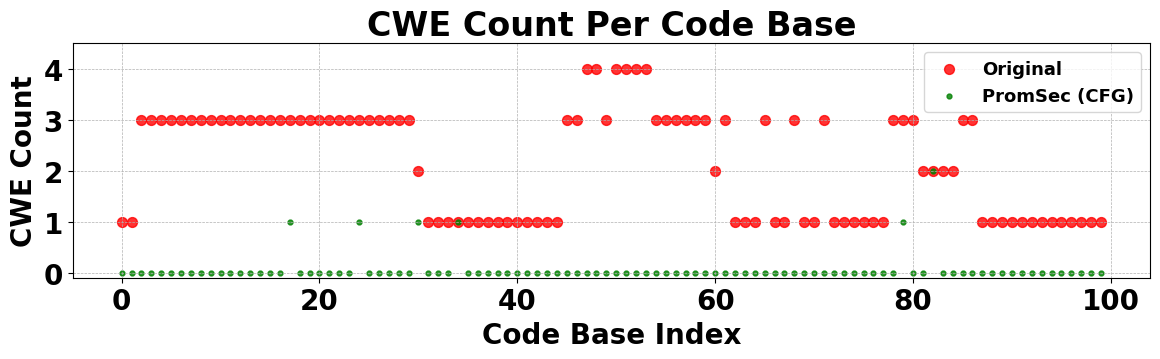

In [28]:


plt.figure(figsize=(12, 4))
point_size = 50
alpha_value = 0.8  # Transparency: 1 is opaque, 0 is fully transparent

index = np.arange(100)

plt.scatter(index, k_org_arr, s=point_size,
            color='r', marker='o', label='Original', alpha=alpha_value)
plt.scatter(index, remaining_k_arr, s=point_size,
            color='g', marker='.', label='PromSec (CFG)', alpha=alpha_value)

plt.xlabel('Code Base Index')  # Capitalized 'Code Base Index'
plt.ylabel('CWE Count')  # Capitalized 'CWEs'
plt.title('CWE Count Per Code Base')  # Capitalized 'CWE Count Per Code Base'
plt.ylim(0, 4.5)
nth = 10  # Display every 5th label
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='best', fontsize=13)
plt.ylim(bottom=-0.1)  # Set the start of the y-axis to 0
# Setting y-axis to have integer ticks only
ax = plt.gca()  # get the current axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig(os.path.join(folder_name, "per_codebase_cfg.png"), dpi=150)
plt.savefig(os.path.join(folder_name, "per_codebase_cfg.pdf"), dpi=150)

#### Plotting the Per-CWE Hisogram 

In [29]:
import itertools
from collections import Counter
org_cwe_freq= Counter(itertools.chain.from_iterable(CWE_org_arr))
prop_cwe_freq = Counter(itertools.chain.from_iterable(remaining_cwe_arr))

In [30]:
org_cwe_freq

Counter({259: 57, 78: 57, 89: 49, 20: 30, 327: 11, 703: 10, 400: 1, 377: 1})

In [31]:
org_cwe_freq

Counter({259: 57, 78: 57, 89: 49, 20: 30, 327: 11, 703: 10, 400: 1, 377: 1})

In [32]:
prop_cwe_freq

Counter({78: 4, 400: 2, 89: 1})

In [33]:
prop_cwe_freq

Counter({78: 4, 400: 2, 89: 1})

In [34]:
plt.rcParams['font.size'] = 15


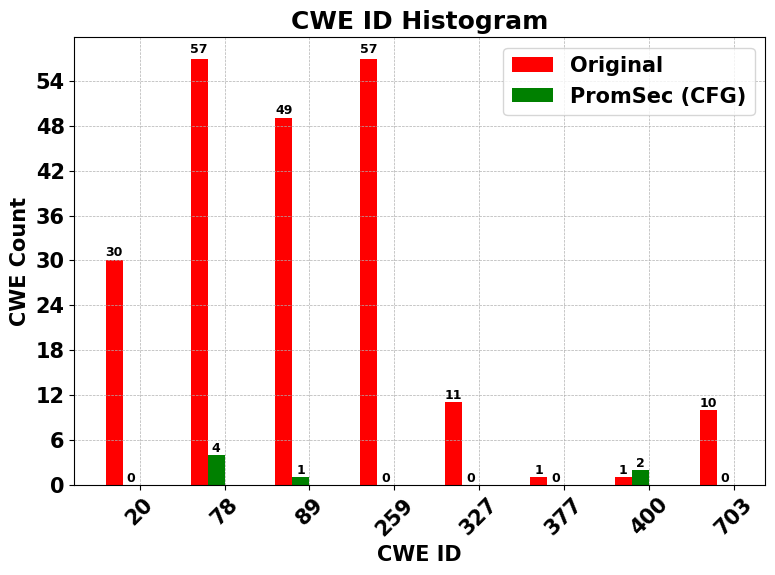

In [35]:
# Convert keys to integers:
org_cwe_freq   = {int(k): v for k, v in org_cwe_freq.items()}
prop_cwe_freq = {int(k): v for k, v in prop_cwe_freq.items()}

# Now you can merge and sort without type conflicts:
all_cwe_ids = sorted(set(org_cwe_freq.keys()) | set(prop_cwe_freq.keys()))

# 2. Plot grouped bar chart
bar_width = 0.2  # Adjusted for 4 bars
r1 = np.arange(len(all_cwe_ids))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(8,6))

def annotate_bars(rects, ax):
    """
    Attach a text label above each bar displaying its height.
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0051*height, 
                '%d' % int(height), 
                ha='center', va='bottom', fontsize=9)

# Create the bar plots and get the bar objects
bars1 = ax.bar(r1, [org_cwe_freq.get(cwe, 0) for cwe in all_cwe_ids], color='red', width=bar_width, label='Original')
bars2 = ax.bar(r2, [prop_cwe_freq.get(cwe, 0) for cwe in all_cwe_ids], color='green', width=bar_width, label='PromSec (CFG)')

# Annotate each of the bars
annotate_bars(bars1, ax)
annotate_bars(bars2, ax)

# Title & Subtitle
plt.title('CWE ID Histogram', fontweight='bold')
plt.xlabel('CWE ID', fontweight='bold')
plt.ylabel('CWE Count', fontweight='bold')

# Set the x-ticks
plt.xticks([r + 1.5 * bar_width for r in range(len(all_cwe_ids))], all_cwe_ids, rotation=45)  # Added rotation for better visualization

# Ensure y-axis only has integer labels
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Create legend & Show graphic
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(folder_name, "per_CWE_cfg.png"), dpi=150)
plt.savefig(os.path.join(folder_name, "per_CWE_cfg.pdf"), dpi=150)
plt.show()


### CWE Cleansing vs. Iteration

In [36]:
req_iter_num_arr = [x + 1 for x in req_iter_num_arr]

In [37]:
plt.rcParams['font.size'] = 13

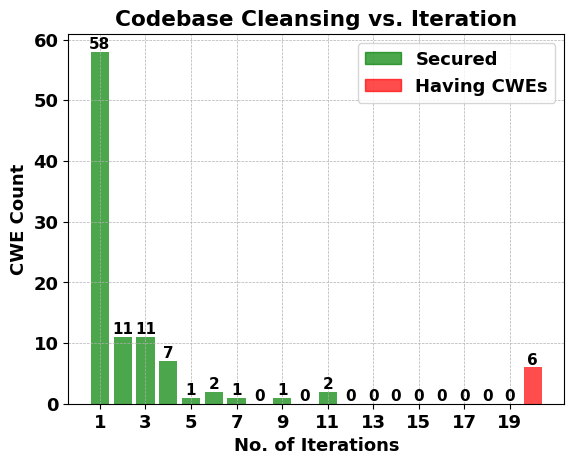

In [38]:


# Assuming req_iter_num_arr is already defined in previous cells
# Create the histogram
hist, bins, patches = plt.hist(req_iter_num_arr, bins=np.arange(min(req_iter_num_arr), max(req_iter_num_arr) + 1.5) - 0.5, rwidth=0.8, color='green', alpha=0.7)

# Distinguish the last bar with a different color
for i in range(len(patches)):
    if bins[i] == 20 - 0.5:  # Adjusting for the bin edge
        patches[i].set_facecolor('red')

# Annotate each bar with its value and set font size
for i in range(len(hist)):
    plt.text(bins[i] + 0.5, hist[i], str(int(hist[i])), ha='center', va='bottom', fontsize=11)

# Add grid, labels, and title
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('No. of Iterations')
plt.ylabel('CWE Count')
plt.title('Codebase Cleansing vs. Iteration')

# Add legend
handles = [plt.Rectangle((0,0),1,1, color='green', alpha=0.7), 
           plt.Rectangle((0,0),1,1, color='red', alpha=0.7)]
labels = ['Secured', 'Having CWEs']
plt.legend(handles, labels, loc='upper right')

# Set x-axis labels to be integers
plt.xticks(np.arange(1, max(req_iter_num_arr) + 1, step=2))

# Save and show the plot
plt.savefig(os.path.join(folder_name, "hist_min_required_iterations_cfg.png"), dpi=150)
plt.savefig(os.path.join(folder_name, "hist_min_required_iterations_cfg.pdf"), dpi=150)
plt.show()

#### Count of Remaining CWEs After 1st Iteration


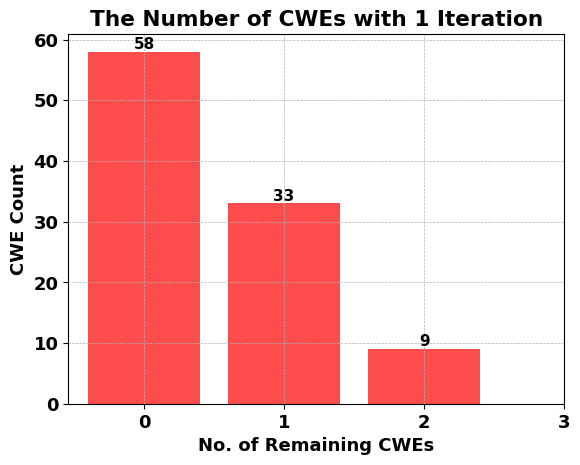

In [39]:
# Create the histogram
hist, bins, patches = plt.hist(k_after_1_iter_arr, bins=np.arange(min(k_after_1_iter_arr), max(k_after_1_iter_arr) + 1.5) - 0.5, rwidth=0.8, color='red', alpha=0.7)
# Annotate each bar with its value and set font size
for i in range(len(hist)):
    plt.text(bins[i] + 0.5, hist[i], str(int(hist[i])), ha='center', va='bottom', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('No. of Remaining CWEs')  # Capitalized 'No. of Remaining CWEs'
plt.ylabel('CWE Count')  # Capitalized 'Count'
plt.title('The Number of CWEs with 1 Iteration')  # Capitalized 'The Number of CWEs with 1 Iteration'
plt.xticks(range(4))

plt.savefig(os.path.join(folder_name, "hist_k_iter1_cfg.png"), dpi=150)
plt.savefig(os.path.join(folder_name, "hist_k_iter1_cfg.pdf"), dpi=150)
plt.show()


## Stop here!